# Adding topography to geological models
***
This chapter shows how to make geological models look more realistic by incorporating topography data:
The data can either be stored in a raster file that can be conveniently loaded into gempy.
For demonstration purposes GemPy also provides a tool to create a random hilly landscape to limit the models on the surface.

***

In [17]:
import sys
sys.path.append("../..")

import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. The common procedure to set up a model:

In [18]:
geo_model = gp.create_model('Single_layer_topo')

gp.init_data(geo_model, extent=[450000, 460000, 70000,80000,-1000,500],resolution = (50,50,50),
                         path_i = os.pardir+"/data/input_data/tut-ch1-7/onelayer_interfaces.csv",
                         path_o = os.pardir+"/data/input_data/tut-ch1-7/onelayer_orient.csv")

Active grids: ['regular']


Single_layer_topo  2019-07-11 12:43

440720 471440  69280 100000

In [19]:
# use happy spring colors! 
geo_model.surfaces.colors.change_colors({'layer1':'#ff8000','basement':'#88cc60'})

,surface,series,order_surfaces,isBasement,color,id
0,layer1,Default series,1,False,#ff8000,1
1,basement,Basement,1,True,#88cc60,2


In [20]:
%matplotlib inline
gp.map_series_to_surfaces(geo_model, {'series':('layer1','basement')})

,surface,series,order_surfaces,isBasement,color,id
0,layer1,series,1,False,#ff8000,1
1,basement,series,2,True,#88cc60,2


In [21]:
s = {'s1': ([450000,75000],[460000,75500],[100,100])}
geo_model.grid.set_section_grid(s)

,start,stop,resolution
s1,"[450000, 75000]","[460000, 75500]","[100, 100]"


### 2. Adding topography

#### 2 a. Load from raster file

In [22]:
fp = os.pardir+"/data/input_data/tut-ch1-7/bogota.tif"

Cropped raster to geo_model.grid.extent.
[450000 460000  70000  80000] [167 167]
storing converted file...
Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[450100.        ,  70100.        ,   -985.        ],
       [450100.        ,  70100.        ,   -955.        ],
       [450100.        ,  70100.        ,   -925.        ],
       ...,
       [460000.        ,  75500.        ,    469.6969697 ],
       [460000.        ,  75500.        ,    484.84848485],
       [460000.        ,  75500.        ,    500.        ]])

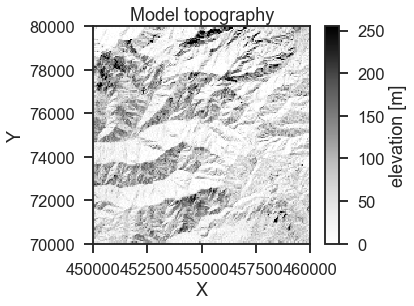

In [23]:
geo_model.set_topography(source='gdal',filepath=fp)

#### 2 b. create fun topography

If there is no topography file, but you think that your model with topography would look significantly cooler, you can use gempys function to generate a random topography based on a fractal grid:

Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[450100.        ,  70100.        ,   -985.        ],
       [450100.        ,  70100.        ,   -955.        ],
       [450100.        ,  70100.        ,   -925.        ],
       ...,
       [460000.        ,  75500.        ,    469.6969697 ],
       [460000.        ,  75500.        ,    484.84848485],
       [460000.        ,  75500.        ,    500.        ]])

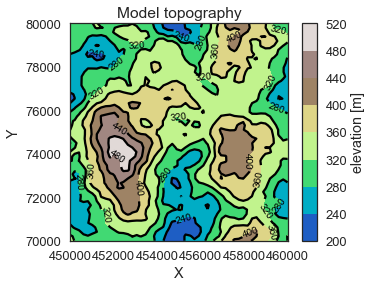

In [8]:
geo_model.set_topography(source='random')

It has additional keywords to play around with:
- fd: fractal dimension, defaults to 2.0. The higher (try 2.9), the rougher the landscape will be.
- d_z: height difference. If none, last 20% of the model in z direction.
- extent: extent in xy direction. If none, geo_model.grid.extent
- resolution: resolution of the topography array. If none, geo_model.grid.resoution. Increasing the resolution leads to much nicer geological maps!

Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[450100.        ,  70100.        ,   -985.        ],
       [450100.        ,  70100.        ,   -955.        ],
       [450100.        ,  70100.        ,   -925.        ],
       ...,
       [460000.        ,  75500.        ,    469.6969697 ],
       [460000.        ,  75500.        ,    484.84848485],
       [460000.        ,  75500.        ,    500.        ]])

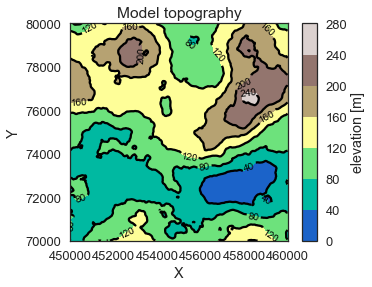

In [9]:
geo_model.set_topography(source='random',fd=1.9, d_z=np.array([0,250]), resolution=np.array([200,200]))

Note that each time this function is called, a new random topography is created. If you particularly like the generated topography or if you have loaded a large file with gdal, you can save the topography object and load it again later:

In [10]:
#save
geo_model.grid.topography.save('test_topo')

saved


Active grids: ['regular' 'topography' 'sections']


Grid Object. Values: 
array([[450100.        ,  70100.        ,   -985.        ],
       [450100.        ,  70100.        ,   -955.        ],
       [450100.        ,  70100.        ,   -925.        ],
       ...,
       [460000.        ,  75500.        ,    469.6969697 ],
       [460000.        ,  75500.        ,    484.84848485],
       [460000.        ,  75500.        ,    500.        ]])

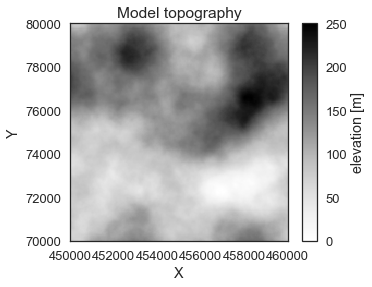

In [11]:
#load
geo_model.set_topography(source='saved',filepath='test_topo.npy')

### Compute model

In [24]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


In [25]:
gp.compute_model(geo_model, compute_mesh=False, set_solutions=True)


Lithology ids 
  [2. 2. 2. ... 1. 1. 1.] 

In [39]:
geo_model.solutions.geological_map[0].reshape(geo_model.grid.topography.resolution)

array([[2., 2., 2., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.],
       ...,
       [2., 2., 2., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.]])

In [33]:
import gdal
import osr

In [ ]:
def write_geotiff(filename, geo_model, [lonmin,latmin,lonmax,latmax]):
    """
    [lonmin,latmin,lonmax,latmax]: in WGS84 lat lon
    """
    array = geo_model.grid.topography.values_3D[:,:,2]
    xmin,ymin,xmax,ymax = [lonmin,latmin,lonmax,latmax]
    nrows,ncols = np.shape(array)
    xres = (xmax-xmin)/float(ncols)
    yres = (ymax-ymin)/float(nrows)
    geotransform=(xmin,xres,0,ymax,0, -yres)   
    # That's (top left x, w-e pixel resolution, rotation (0 if North is up), 
    #         top left y, rotation (0 if North is up), n-s pixel resolution)
    # I don't know why rotation is in twice???

    output_raster = gdal.GetDriverByName('GTiff').Create(filename,ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
    output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
    srs = osr.SpatialReference()                 # Establish its coordinate encoding
    srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
                                                 # Anyone know how to specify the 
                                                 # IAU2000:49900 Mars encoding?
    output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
                                                       # to the file
    output_raster.GetRasterBand(1).WriteArray(array)   # Writes my array to the raster

    output_raster.FlushCache()

In [40]:
def export_geotiff(path, geo_model, geo_map=None, geotiff_filepath=None):
    """

    Args:
        path (str): Filepath for the exported geotiff, must end in .tif
        geo_map (np.ndarray): 2-D array containing the geological map
        cmap (matplotlib colormap): The colormap to be used for the export
        geotiff_filepath (str): Filepath of the template geotiff

    Returns:
        Saves the geological map as a geotiff to the given path.
    """
    from matplotlib.cm import ScalarMappable as SM
    plot = gp.plot.PlotData2D(geo_model)
    cmap = plot._cmap
    norm = plot._norm
    
    if geo_map == None:
        geo_map = geo_model.solutions.geological_map[0].reshape(geo_model.grid.topography.resolution)
    
    if geotiff_filepath == None:
        
    # **********************************************************************
    geo_map_rgb = SM(norm=norm, cmap=cmap).to_rgba(geo_map.T) # r,g,b,alpha
    # **********************************************************************
    # gdal.UseExceptions()
    print(geo_map_rgb.shape)
    ds = gdal.Open(geotiff_filepath)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    [cols, rows] = arr.shape

    outFileName = path
    driver = gdal.GetDriverByName("GTiff")
    options = ['PROFILE=GeoTiff', 'PHOTOMETRIC=RGB', 'COMPRESS=JPEG']
    outdata = driver.Create(outFileName, rows, cols, 3, gdal.GDT_Byte, options=options)

    outdata.SetGeoTransform(ds.GetGeoTransform())  # sets same geotransform as input
    outdata.SetProjection(ds.GetProjection())  # sets same projection as input
    outdata.GetRasterBand(1).WriteArray(geo_map_rgb[:, ::-1, 0].T * 256)
    print(geo_map_rgb[:, ::-1, 0].T)
    outdata.GetRasterBand(2).WriteArray(geo_map_rgb[:, ::-1, 1].T * 256)
    outdata.GetRasterBand(3).WriteArray(geo_map_rgb[:, ::-1, 2].T * 256)
    outdata.GetRasterBand(1).SetColorInterpretation(gdal.GCI_RedBand)
    outdata.GetRasterBand(2).SetColorInterpretation(gdal.GCI_GreenBand)
    outdata.GetRasterBand(3).SetColorInterpretation(gdal.GCI_BlueBand)
    # outdata.GetRasterBand(4).SetColorInterpretation(gdal.GCI_AlphaBand)  # alpha band

    # outdata.GetRasterBand(1).SetNoDataValue(999)##if you want these values transparent
    outdata.FlushCache()  # saves to disk
    outdata = None  # closes file (important)
    band = None
    ds = None

    print("Successfully exported geological map to "+path)

In [41]:
export_geotiff('hallotest.tif', geo_model, geotiff_filepath=fp)

(167, 167, 4)
[[0.53333333 0.53333333 0.53333333 ... 1.         1.         1.        ]
 [0.53333333 0.53333333 0.53333333 ... 1.         1.         1.        ]
 [0.53333333 0.53333333 0.53333333 ... 1.         1.         1.        ]
 ...
 [0.53333333 0.53333333 0.53333333 ... 1.         1.         1.        ]
 [0.53333333 0.53333333 0.53333333 ... 1.         1.         1.        ]
 [0.53333333 0.53333333 0.53333333 ... 1.         1.         1.        ]]
Successfully exported geological map to hallotest.tif


In [36]:
%debug

> c:\users\elisa\anaconda3\envs\gempy_n\lib\site-packages\osgeo\gdal_array.py(378)BandWriteArray()
    376 
    377     if xsize + xoff > band.XSize or ysize + yoff > band.YSize:
--> 378         raise ValueError("array larger than output file, or offset off edge")
    379 
    380     datatype = NumericTypeCodeToGDALTypeCode( array.dtype.type )

ipdb> xsize
27889
ipdb> ysize
1
ipdb> exit


#### Visualize:
Now, the solutions object does also contain the computed geological map. It can be visualized using the plot_map function:

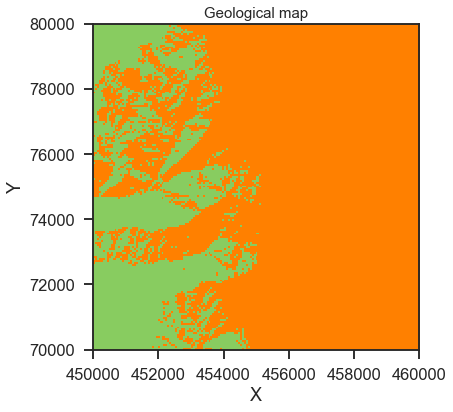

In [42]:
gp.plot.plot_map(geo_model, contour_lines=False, show_data=False)

AssertionError: 

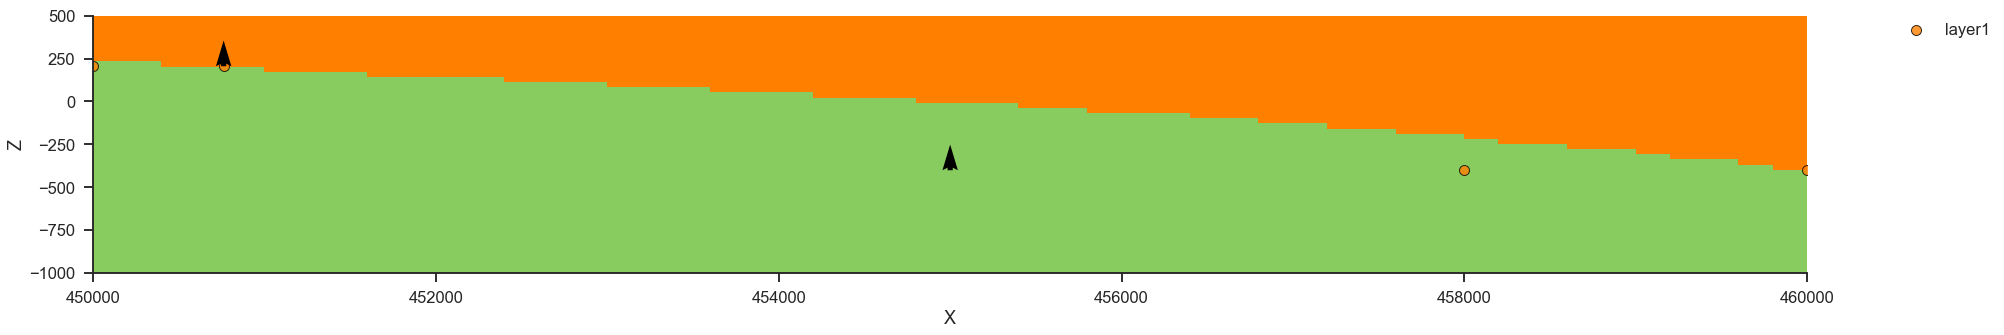

In [16]:
gp.plot.plot_section(geo_model, cell_number=4, block=geo_model.solutions.lith_block,
                         direction='y', show_data=True,show_faults=False)

In [ ]:
gp.plot.plot_predef_sections(geo_model,show_traces=False,figsize = (8,8))

In [ ]:
gp.plot.plot_predef_sections(geo_model, section_names=['s1'],show_traces=False)